In [1]:
import numpy as np
import pandas as pd 
import spacy 
from datasets import load_dataset
import pickle
import string
from string import digits
import re

In [2]:
# dataset = load_dataset("cfilt/iitb-english-hindi")
# def save_object(obj, path):
#     with open(path, 'wb') as file:
#         pickle.dump(obj, file)
    
    
# save_object(dataset, 'dataset_english_hindi')


# #already downloaded

In [3]:
with open('dataset_english_hindi', 'rb') as file:
    dataset = pickle.load(file)

In [4]:
train = pd.DataFrame(dataset['train']['translation'])
test = pd.DataFrame(dataset['test']['translation'])
val = pd.DataFrame(dataset['validation']['translation'])

In [5]:
train.head()

,en,hi
0,Give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
1,Accerciser Accessibility Explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक
2,The default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लग-इन खाका
3,The default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका
4,A list of plugins that are disabled by default,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...


In [6]:
train.shape, test.shape, val.shape

((1659083, 2), (2507, 2), (520, 2))

In [7]:
# Reducing my data to have only 2k sentences...will change it later
train = train.sample(2000)

## Data Preprocessing

In [10]:
train['en']=train['en'].apply(lambda x: x.lower())
train['hi']=train['hi'].apply(lambda x: x.lower())
train['en']=train['en'].apply(lambda x: re.sub("'", '', x))
train['hi']=train['hi'].apply(lambda x: re.sub("'", '', x))
exclude = set(string.punctuation) # Set of all special characters
train['en']=train['en'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
train['hi']=train['hi'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
remove_digits = str.maketrans('', '', digits)
train['en']=train['en'].apply(lambda x: x.translate(remove_digits))
train['hi']=train['hi'].apply(lambda x: x.translate(remove_digits))
train['hi'] = train['hi'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))
train['en']=train['en'].apply(lambda x: x.strip())
train['hi']=train['hi'].apply(lambda x: x.strip())
train['en']=train['en'].apply(lambda x: re.sub(" +", " ", x))
train['hi']=train['hi'].apply(lambda x: re.sub(" +", " ", x))
train['hi'] = train['hi'].apply(lambda x : 'START_ '+ x + ' _END')
train['length_eng_sentence']=train['en'].apply(lambda x:len(x.split(" ")))
train['length_hin_sentence']=train['hi'].apply(lambda x:len(x.split(" ")))
train.head()

,en,hi,length_eng_sentence,length_hin_sentence
1593765,this division of the rigveda is most popular a...,START_ start ऋग्वेद का यह मंडल सबसे लोकप्रिय औ...,32,35
1633986,governorgeneral dalhousie himself travelled to...,START_ start गवर्नर जनरल डलहौज़ी ने हीरा प्राप्...,17,22
1125563,he cultivates fishes such as rohu catla bata m...,START_ start उन्होंतने अपने तालाब में रोहू काट...,20,25
248358,and every time i called them that you may forg...,START_ start और जब भी मैंने उन्हें बुलाया ताकि...,32,44
273933,but they cried him lies and hamstrung her so t...,START_ start किन्तु उन्होंने उसे झुठलाया और उस...,19,32


In [13]:
all_eng_words=set()
for eng in train['en']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_hindi_words=set()
for hin in train['hi']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)
print("maximum length of Hindi Sentence ",max(train['length_hin_sentence']))
print("maximum length of English Sentence ",max(train['length_eng_sentence']))
len(all_eng_words), len(all_hindi_words)

maximum length of Hindi Sentence  180
maximum length of English Sentence  157


(6282, 7255)

In [15]:
max_length_src=max(train['length_hin_sentence'])
max_length_tar=max(train['length_eng_sentence'])

In [17]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words) + 1 # for padding
num_encoder_tokens, num_decoder_tokens

(6282, 7256)

In [18]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [30]:
X, Y = train['en'], train['hi']

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer_eng = Tokenizer()
tokenizer_eng.fit_on_texts(X.values)
total_words_eng = len(tokenizer_eng.word_index) + 1

tokenizer_hindi = Tokenizer()
tokenizer_hindi.fit_on_texts(Y.values)
total_words_hindi = len(tokenizer_hindi.word_index) + 1

# Convert sentences to sequences
X_seq = tokenizer_eng.texts_to_sequences(X.values)
Y_seq = tokenizer_hindi.texts_to_sequences(Y.values)

# Pad sequences for input data
max_sequence_length = max(len(seq) for seq in X_seq + Y_seq)
X_padded = pad_sequences(X_seq, maxlen=max_sequence_length, padding='post')
Y_padded = pad_sequences(X_seq, maxlen=max_sequence_length, padding='post')

In [32]:
X_padded.shape, Y_padded.shape

((2000, 180), (2000, 180))

In [33]:
X_padded

array([[  17,  548,    2, ...,    0,    0,    0],
       [2299, 1352,  299, ...,    0,    0,    0],
       [  13, 2302, 2303, ...,    0,    0,    0],
       ...,
       [6277,    0,    0, ...,    0,    0,    0],
       [ 319,   14, 6278, ...,    0,    0,    0],
       [6282,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [42]:
import matplotlib.pyplot as plt

def plot_loss(history):
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Epoch 1/10
63/63 [==============================] - 2s 8ms/step - loss: -7809.7339
Epoch 2/10
63/63 [==============================] - 0s 8ms/step - loss: -22610.0605
Epoch 3/10
63/63 [==============================] - 0s 7ms/step - loss: -42687.9570
Epoch 4/10
63/63 [==============================] - 0s 7ms/step - loss: -72919.7031
Epoch 5/10
63/63 [==============================] - 0s 8ms/step - loss: -127239.8359
Epoch 6/10
63/63 [==============================] - 0s 7ms/step - loss: -218995.3438
Epoch 7/10
63/63 [==============================] - 0s 8ms/step - loss: -368882.2188
Epoch 8/10
63/63 [==============================] - 0s 8ms/step - loss: -643400.6875
Epoch 9/10
63/63 [==============================] - 0s 7ms/step - loss: -1044062.6875
Epoch 10/10
63/63 [==============================] - 0s 8ms/step - loss: -1593352.7500


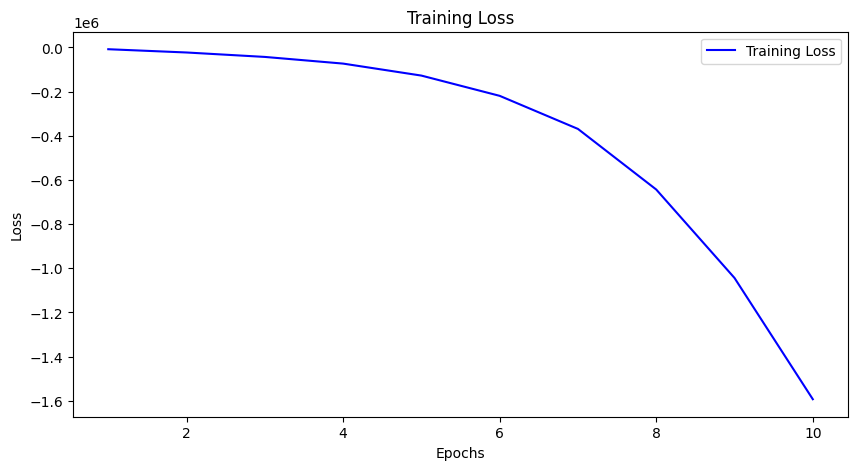

Epoch 1/10
63/63 [==============================] - 2s 7ms/step - loss: -4614.7710
Epoch 2/10
63/63 [==============================] - 0s 7ms/step - loss: -17833.7344
Epoch 3/10
63/63 [==============================] - 0s 8ms/step - loss: -35135.4375
Epoch 4/10
63/63 [==============================] - 0s 8ms/step - loss: -61493.3672
Epoch 5/10
63/63 [==============================] - 0s 7ms/step - loss: -102911.5078
Epoch 6/10
63/63 [==============================] - 0s 7ms/step - loss: -181743.7188
Epoch 7/10
63/63 [==============================] - 0s 7ms/step - loss: -321900.5312
Epoch 8/10
63/63 [==============================] - 0s 8ms/step - loss: -564082.5625
Epoch 9/10
63/63 [==============================] - 0s 7ms/step - loss: -938245.7500
Epoch 10/10
63/63 [==============================] - 0s 7ms/step - loss: -1510591.0000


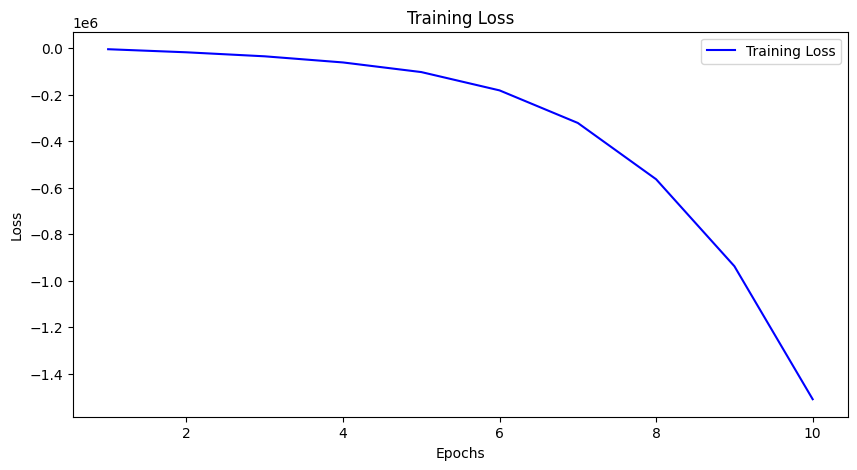

In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np

# Function to build the continuous VAE model
def build_continuous_vae(input_dim, latent_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(256, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    decoder_h = Dense(128, activation='relu')
    decoder_mean = Dense(input_dim, activation='sigmoid')

    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    xent_loss = input_dim * binary_crossentropy(inputs, x_decoded_mean)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae = Model(inputs, x_decoded_mean)
    vae.add_loss(vae_loss)
    clip_value = 0.5  
    optimizer = Adam(learning_rate=0.0001, clipvalue=clip_value)
    vae.compile(optimizer=optimizer)

    return vae

latent_dim = 100  
input_dim = X_padded.shape[1]

continuous_vae_english = build_continuous_vae(input_dim, latent_dim)
plot_loss(continuous_vae_english.fit(X_padded, X_padded, epochs=10, batch_size=32))

input_dim = Y_padded.shape[1]

continuous_vae_hindi = build_continuous_vae(input_dim, latent_dim)
plot_loss(continuous_vae_hindi.fit(Y_padded, Y_padded, epochs=10, batch_size=32))

Epoch 1/10


63/63 [==============================] - 2s 13ms/step - loss: 11481803.0000
Epoch 2/10
63/63 [==============================] - 0s 5ms/step - loss: 11325049.0000
Epoch 3/10
63/63 [==============================] - 0s 5ms/step - loss: 10979578.0000
Epoch 4/10
63/63 [==============================] - 0s 5ms/step - loss: 10359009.0000
Epoch 5/10
63/63 [==============================] - 0s 6ms/step - loss: 9496013.0000
Epoch 6/10
63/63 [==============================] - 0s 5ms/step - loss: 8667692.0000
Epoch 7/10
63/63 [==============================] - 0s 5ms/step - loss: 8144991.5000
Epoch 8/10
63/63 [==============================] - 0s 5ms/step - loss: 7984006.0000
Epoch 9/10
63/63 [==============================] - 0s 6ms/step - loss: 8181223.0000
Epoch 10/10
63/63 [==============================] - 0s 5ms/step - loss: 8675032.0000


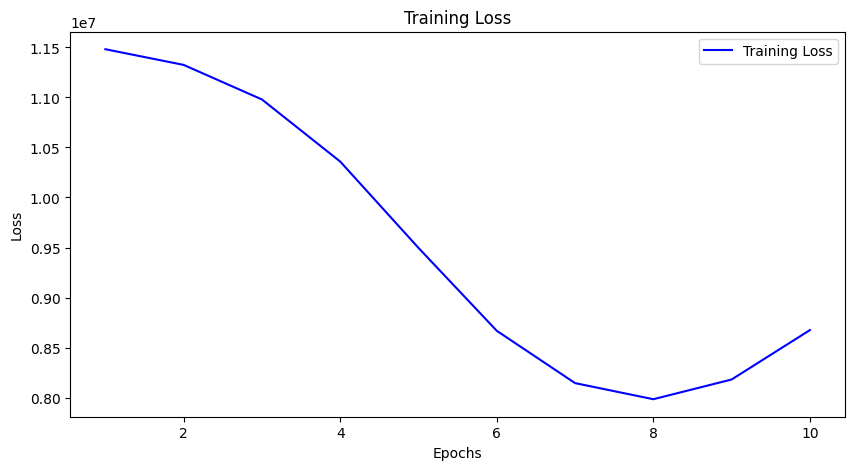

Epoch 1/10


63/63 [==============================] - 2s 15ms/step - loss: 11474650.0000
Epoch 2/10
63/63 [==============================] - 0s 6ms/step - loss: 11319710.0000
Epoch 3/10
63/63 [==============================] - 0s 5ms/step - loss: 10961284.0000
Epoch 4/10
63/63 [==============================] - 0s 5ms/step - loss: 10310402.0000
Epoch 5/10
63/63 [==============================] - 0s 5ms/step - loss: 9407169.0000
Epoch 6/10
63/63 [==============================] - 0s 5ms/step - loss: 8596266.0000
Epoch 7/10
63/63 [==============================] - 0s 5ms/step - loss: 8164203.0000
Epoch 8/10
63/63 [==============================] - 0s 5ms/step - loss: 8170554.0000
Epoch 9/10
63/63 [==============================] - 0s 5ms/step - loss: 8588739.0000
Epoch 10/10
63/63 [==============================] - 0s 5ms/step - loss: 9460262.0000


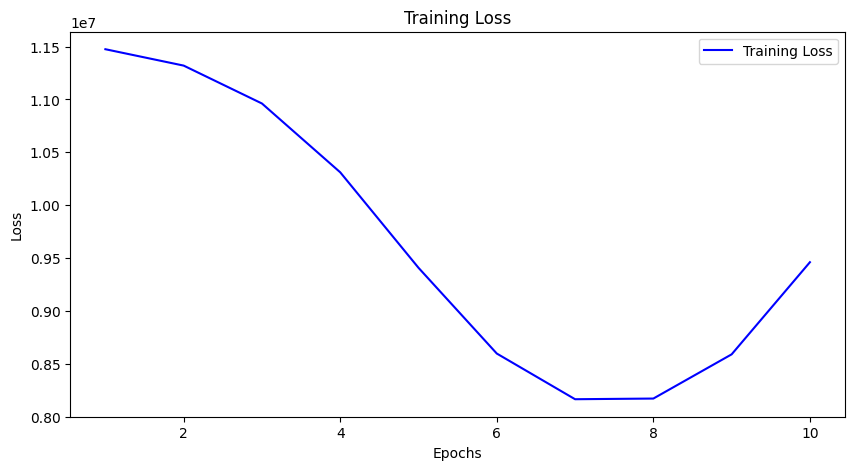

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Reshape, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np

def build_discrete_vq_vae(input_dim, codebook_size, embedding_dim):
    inputs = Input(shape=(input_dim,))
    encoder = Dense(256, activation='relu')(inputs)
    encoder = Dense(128, activation='relu')(encoder)

    z_e = Dense(embedding_dim)(encoder)
    z_q = Embedding(codebook_size, embedding_dim)(K.argmax(z_e, axis=-1))

    decoder = Dense(128, activation='relu')(z_q)
    decoder = Dense(256, activation='relu')(decoder)
    outputs = Dense(input_dim, activation='sigmoid')(decoder)

    commitment_loss = 0.1  # Adjust based on experimentation
    quantization_loss = commitment_loss * K.mean((K.stop_gradient(z_e) - z_q) ** 2)

    recon_loss = input_dim * categorical_crossentropy(inputs, outputs)

    vq_vae_loss = recon_loss + quantization_loss

    clip_value = 0.5  
    optimizer = Adam(learning_rate=0.0001, clipvalue=clip_value) # Reduce the learning rate
    vq_vae = Model(inputs, outputs)
    vq_vae.add_loss(vq_vae_loss)
    vq_vae.compile(optimizer=optimizer)

    return vq_vae

codebook_size = 32  
embedding_dim = 64  
input_dim = X_padded.shape[1]

discrete_vq_vae_english = build_discrete_vq_vae(input_dim, codebook_size, embedding_dim)
plot_loss(discrete_vq_vae_english.fit(X_padded, X_padded, epochs=10, batch_size=32))

input_dim = Y_padded.shape[1]

discrete_vq_vae_hindi = build_discrete_vq_vae(input_dim, codebook_size, embedding_dim)
plot_loss(discrete_vq_vae_hindi.fit(Y_padded, Y_padded, epochs=10, batch_size=32))


In [53]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Embedding, Flatten, Reshape
# from tensorflow.keras.models import Model
# from tensorflow.keras import backend as K
# from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras.optimizers import Adam
# import numpy as np

# def build_shared_encoder(latent_dim):
#     inputs = Input(shape=(latent_dim,))
#     x = Dense(128, activation='relu')(inputs)
#     x = BatchNormalization()(x)
#     shared_encoder_output = Dense(latent_dim)(x)

#     shared_encoder = Model(inputs, shared_encoder_output)
#     return shared_encoder

# def build_shared_decoder(latent_dim, input_dim):
#     inputs = Input(shape=(latent_dim,))
#     x = Dense(128, activation='relu')(inputs)
#     x = BatchNormalization()(x)
#     shared_decoder_output = Dense(input_dim, activation='sigmoid')(x)

#     shared_decoder = Model(inputs, shared_decoder_output)
#     return shared_decoder
# latent_dim = 100  
# input_dim = X_padded.shape[1]
# codebook_size = 32  
# embedding_dim = 64  

# continuous_vae_english = build_continuous_vae(input_dim, latent_dim)
# history_continuous_english = continuous_vae_english.fit(X_padded, X_padded, epochs=10, batch_size=32)

# continuous_vae_hindi = build_continuous_vae(input_dim, latent_dim)
# history_continuous_hindi = continuous_vae_hindi.fit(Y_padded, Y_padded, epochs=10, batch_size=32)

# continuous_rep_english = continuous_vae_english.predict(X_padded)
# continuous_rep_hindi = continuous_vae_hindi.predict(Y_padded)

# discrete_vq_vae_english = build_discrete_vq_vae(input_dim, codebook_size, embedding_dim)
# history_discrete_english = discrete_vq_vae_english.fit(X_padded, X_padded, epochs=10, batch_size=32)

# discrete_vq_vae_hindi = build_discrete_vq_vae(input_dim, codebook_size, embedding_dim)
# history_discrete_hindi = discrete_vq_vae_hindi.fit(Y_padded, Y_padded, epochs=10, batch_size=32)

# shared_encoder = build_shared_encoder(latent_dim)
# shared_encoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# shared_encoder.fit(continuous_rep_english, continuous_rep_hindi, epochs=10, batch_size=32)

# def build_adversarial_model(shared_encoder, discriminator):
#     input_english = Input(shape=(latent_dim,))
#     input_hindi = Input(shape=(latent_dim,))

#     encoded_english = shared_encoder(input_english)
#     encoded_hindi = shared_encoder(input_hindi)

#     validity_english = discriminator(encoded_english)
#     validity_hindi = discriminator(encoded_hindi)

#     adversarial_model = Model([input_english, input_hindi], [validity_english, validity_hindi])
#     adversarial_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

#     return adversarial_model

# discriminator = build_discriminator(latent_dim)
# discriminator.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# adversarial_model = build_adversarial_model(shared_encoder, discriminator)
# adversarial_model.fit([continuous_rep_english, continuous_rep_hindi], [np.ones((len(continuous_rep_english), 1)),
#                                                                        np.zeros((len(continuous_rep_english), 1))],
#                      epochs=10, batch_size=32)

# shared_decoder = build_shared_decoder(latent_dim, input_dim)
# shared_decoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# shared_decoder.fit(continuous_rep_english, X_padded, epochs=10, batch_size=32)

Epoch 1/10
63/63 [==============================] - 2s 7ms/step - loss: -6712.9229
Epoch 2/10
63/63 [==============================] - 0s 8ms/step - loss: -19859.8320
Epoch 3/10
63/63 [==============================] - 0s 7ms/step - loss: -37269.7383
Epoch 4/10
63/63 [==============================] - 0s 8ms/step - loss: -62847.4375
Epoch 5/10
63/63 [==============================] - 0s 7ms/step - loss: -104820.8750
Epoch 6/10
63/63 [==============================] - 1s 8ms/step - loss: -179039.1406
Epoch 7/10
63/63 [==============================] - 0s 8ms/step - loss: -309261.7188
Epoch 8/10
63/63 [==============================] - 0s 8ms/step - loss: -533612.8750
Epoch 9/10
63/63 [==============================] - 0s 8ms/step - loss: -940619.8750
Epoch 10/10
63/63 [==============================] - 0s 8ms/step - loss: -1456130.1250
Epoch 1/10
63/63 [==============================] - 2s 8ms/step - loss: -6400.8564
Epoch 2/10
63/63 [==============================] - 0s 7ms/step - loss

63/63 [==============================] - 2s 14ms/step - loss: 11457928.0000
Epoch 2/10
63/63 [==============================] - 0s 5ms/step - loss: 11213950.0000
Epoch 3/10
63/63 [==============================] - 0s 5ms/step - loss: 10658385.0000
Epoch 4/10
63/63 [==============================] - 0s 5ms/step - loss: 9689431.0000
Epoch 5/10
63/63 [==============================] - 0s 6ms/step - loss: 8655623.0000
Epoch 6/10
63/63 [==============================] - 0s 5ms/step - loss: 8121774.5000
Epoch 7/10
63/63 [==============================] - 0s 5ms/step - loss: 8068704.5000
Epoch 8/10
63/63 [==============================] - 0s 5ms/step - loss: 8557841.0000
Epoch 9/10
63/63 [==============================] - 0s 5ms/step - loss: 9423337.0000
Epoch 10/10
63/63 [==============================] - 0s 5ms/step - loss: 10896840.0000
Epoch 1/10


63/63 [==============================] - 2s 15ms/step - loss: 11481925.0000
Epoch 2/10
63/63 [==============================] - 0s 6ms/step - loss: 11342473.0000
Epoch 3/10
63/63 [==============================] - 0s 6ms/step - loss: 11044596.0000
Epoch 4/10
63/63 [==============================] - 0s 5ms/step - loss: 10491149.0000
Epoch 5/10
63/63 [==============================] - 0s 5ms/step - loss: 9679245.0000
Epoch 6/10
63/63 [==============================] - 0s 5ms/step - loss: 8829127.0000
Epoch 7/10
63/63 [==============================] - 0s 5ms/step - loss: 8266283.5000
Epoch 8/10
63/63 [==============================] - 2s 28ms/step - loss: 8070128.0000
Epoch 9/10
63/63 [==============================] - 0s 5ms/step - loss: 8259655.0000
Epoch 10/10
63/63 [==============================] - 0s 5ms/step - loss: 8765084.0000
Epoch 1/10


ValueError: in user code:

    File "/home/imroze/Vaibhav/miniconda/envs/vae/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/imroze/Vaibhav/miniconda/envs/vae/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/imroze/Vaibhav/miniconda/envs/vae/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/imroze/Vaibhav/miniconda/envs/vae/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/home/imroze/Vaibhav/miniconda/envs/vae/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/imroze/Vaibhav/miniconda/envs/vae/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_28" is incompatible with the layer: expected shape=(None, 100), found shape=(None, 180)
